In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import jax
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.algorithm import oasis, oasis_adaptive
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *

plt.rcParams["figure.figsize"]=6,6

In [48]:
key = random.PRNGKey(12)

In [49]:
B = 300 # Number of operators (and images, B=N)
d = B # Image dimension

In [50]:
key, subkey = random.split(key)
x0 = 13 + random.normal(subkey, (d,))

In [51]:
# Generate operators 

A = np.zeros((B, d, d))
for i in range(0,B):
    #print(i)
    diag_i = np.ones(d)
    diag_i[:(i+1)] = 0

    A[i] = np.diag(diag_i)

In [52]:
# Generate measurements
b = jnp.array([Ai@x0 for Ai in A])

# Add noise to the measurements
key, subkey = random.split(key)

sigma = 0.01

b = b + random.normal(subkey, b.shape) * sigma



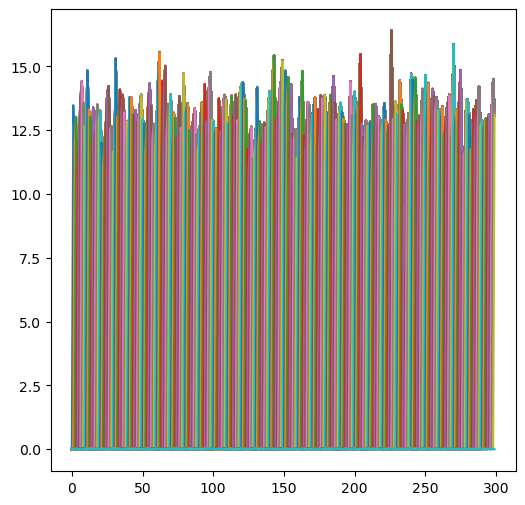

In [53]:
for i in range(b.shape[0]):
    plt.plot(b[i])


In [54]:
@jax.jit
def loss_term(x, Ai, bi, alpha):
    return 1/2*jnp.sum(jnp.conj(Ai@x-bi)*(Ai@x-bi)) + alpha * jnp.sum(jnp.conj(x)*x)

@jax.jit
def loss_sum(x, A, b, alpha):
    return jnp.mean(jax.vmap(loss_term, in_axes = (None, 0, 0, None))(x, A, b, alpha))

@jax.jit
def grad_term(x, Ai, bi, alpha):
    return jax.grad(loss_term)(x, Ai, bi, alpha)



In [55]:
#print(loss_term(x0,A[0],b[0], 1))
#print(loss_sum(x0, A, b, 1))
#print(grad_term(x0,A[0],b[0], 1))

### "Global" parameters

In [56]:
alpha = 1e-2
b1sol = b[0,1]/(1+alpha*B)

key, subkey = random.split(key)
x_init = random.normal(subkey, x0.shape)

### GD with precon

In [57]:
AA = jnp.sum(jax.vmap(lambda Ai : Ai.T @ Ai, in_axes = 0)(A), axis = 0)

D = jnp.diag(AA)+d * alpha
u, v = jnp.linalg.eigh(AA + d*alpha *jnp.eye(d))

100.66666666666667


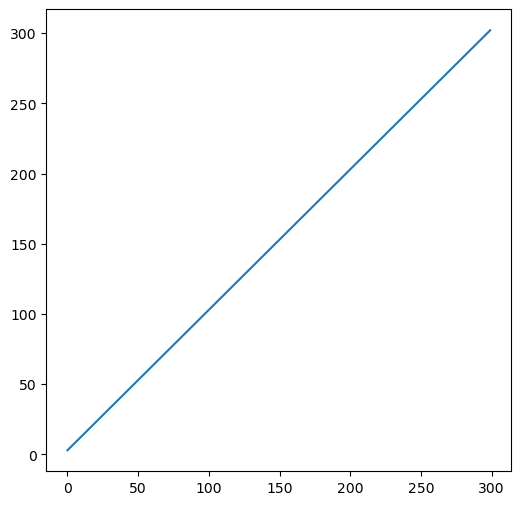

In [58]:
plt.plot(u)
print(u[-1]/u[0])

In [310]:
P = 1/D
#P = jnp.ones(x0.shape)

In [311]:
adaptive_step_size = False

In [312]:
x_gd = x_init

x_gd_all = [x_gd]
cost_gd = [loss_sum(x_gd, A, b, alpha)]
err_x_gd = [jnp.linalg.norm(x_gd-x0)]
err_b1_gd = [b1sol - x_gd[1]]

#eta = 0.001
#eta = 100
#eta = 0.005
eta = 1
etas = [eta]
epochs = 30

for epoch in tqdm(range(epochs)):
    
    
    gradx0 = jnp.sum(jax.vmap(grad_term, in_axes = (None, 0, 0, None))(x_gd, A, b, alpha), axis=0)
    fx0 = loss_sum(x_gd, A, b, alpha)
    
    x1 = x_gd - eta * P * gradx0
    fx1 = loss_sum(x1, A, b, alpha)
    
    if adaptive_step_size:
        while fx1 > fx0 - 0.001 * eta * jnp.real(jnp.sum(jnp.conj(gradx0) * P * gradx0)):
            eta = eta / 2
            x1 = x_gd - eta * P * gradx0
            fx1 = loss_sum(x1, A, b, alpha) 
            
    x_gd = x1
    
    cost_gd.append(fx1)
    err_x_gd.append(jnp.linalg.norm(x_gd-x0))
    err_b1_gd.append(b1sol - x_gd[1])
    x_gd_all.append(x_gd)
    etas.append(eta)
            
cost_gd = jnp.array(cost_gd)
err_x_gd = jnp.array(err_x_gd)
err_b1_gd = jnp.array(err_b1_gd)
x_gd_all = jnp.array(x_gd_all)
etas = jnp.array(etas)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.61it/s]


In [306]:
cost_gd_noprecon = cost_gd
err_x_gd_noprecon = err_x_gd
x_gd_noprecon = x_gd

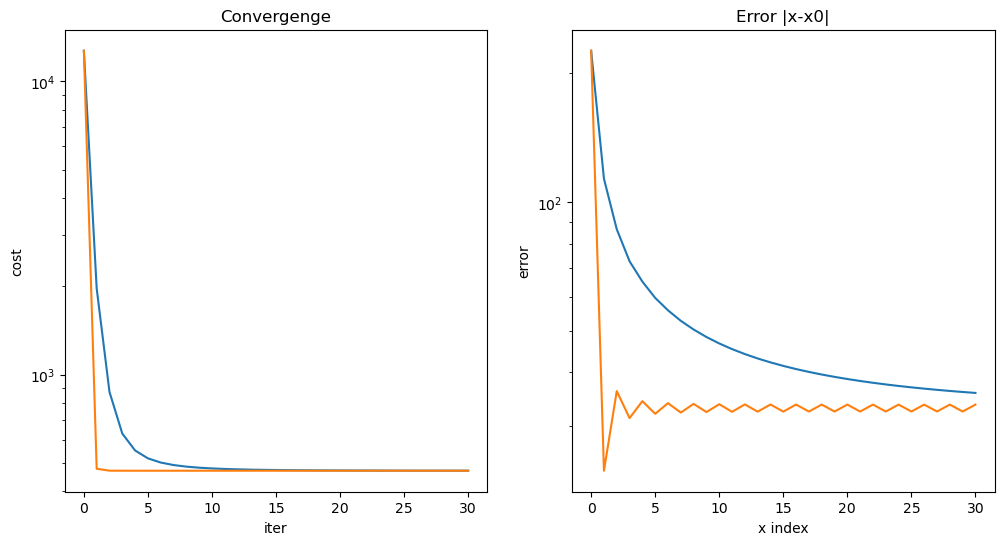

In [313]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(cost_gd_noprecon)
plt.semilogy(cost_gd)
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Convergenge')

plt.subplot(122)
plt.semilogy(err_x_gd_noprecon[:100])
plt.semilogy(err_x_gd[:100])

plt.xlabel('x index')
plt.ylabel('error')
plt.title('Error |x-x0|')

plt.rcParams["figure.figsize"]=6,6

### No precon, "biased"

In [314]:
D[1]

Array(4., dtype=float64)

In [185]:
AA[1,1]

Array(1., dtype=float64)

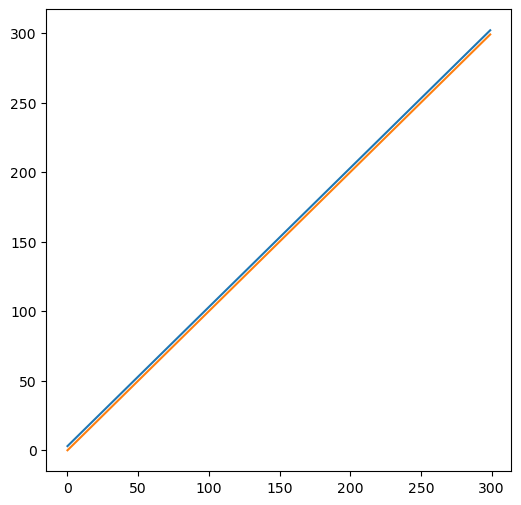

In [188]:
plt.plot(D)
plt.plot(jnp.diag(AA))

In [315]:
P = jnp.ones(x0.shape)

In [316]:
x_gd_b = D

x_gd_all_b = [x_gd]
cost_gd_b = [loss_sum(x_gd_b, A, b, alpha)]
err_x_gd_b = [jnp.linalg.norm(x_gd_b-x0)]
err_b1_gd_b = [b1sol - x_gd_b[1]]

eta = 0.005
#eta = 1
etas_b = [eta]
epochs = 30

for epoch in tqdm(range(epochs)):
    
    
    gradx0 = jnp.sum(jax.vmap(grad_term, in_axes = (None, 0, 0, None))(x_gd_b, A, b, alpha), axis=0)
    fx0 = loss_sum(x_gd_b, A, b, alpha)
    
    x1 = x_gd_b - eta * P * gradx0
    fx1 = loss_sum(x1, A, b, alpha)
    
    if adaptive_step_size:
        while fx1 > fx0 - 0.001 * eta * jnp.real(jnp.sum(jnp.conj(gradx0) * P * gradx0)):
            eta = eta / 2
            x1 = x_gd_b - eta * P * gradx0
            fx1 = loss_sum(x1, A, b, alpha) 
            
    x_gd_b = x1
    
    cost_gd_b.append(fx1)
    err_x_gd_b.append(jnp.linalg.norm(x_gd_b-x0))
    err_b1_gd_b.append(b1sol - x_gd_b[1])
    x_gd_all_b.append(x_gd_b)
    etas_b.append(eta)
            
cost_gd_b = jnp.array(cost_gd_b)
err_x_gd_b = jnp.array(err_x_gd_b)
err_b1_gd_b = jnp.array(err_b1_gd_b)
x_gd_all_b = jnp.array(x_gd_all_b)
etas_b = jnp.array(etas_b)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.47it/s]


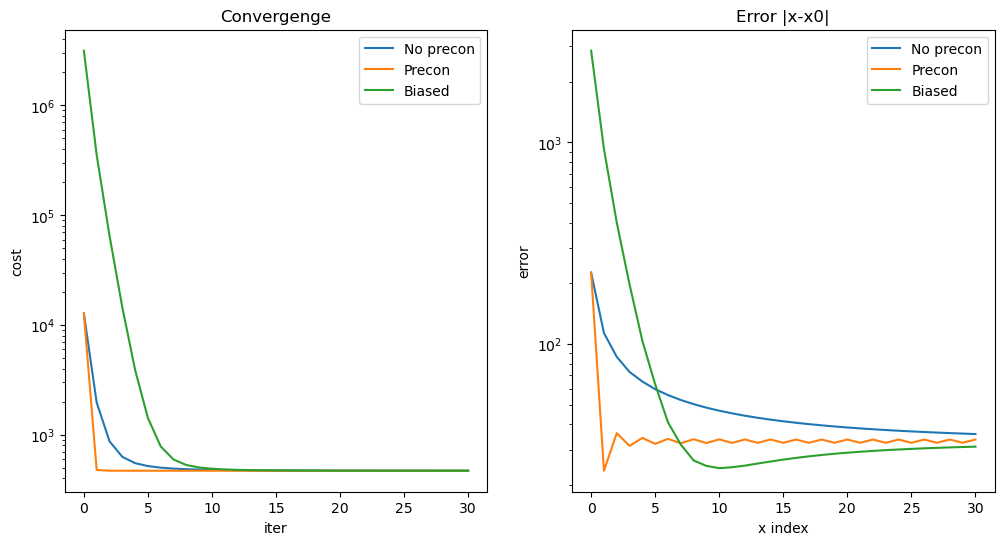

In [317]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(cost_gd_noprecon)
plt.semilogy(cost_gd)
plt.semilogy(cost_gd_b)
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Convergenge')
plt.legend(['No precon', 'Precon', 'Biased'])

plt.subplot(122)
plt.semilogy(err_x_gd_noprecon[:100])
plt.semilogy(err_x_gd[:100])
plt.semilogy(err_x_gd_b[:100])
plt.xlabel('x index')
plt.ylabel('error')
plt.title('Error |x-x0|')
plt.legend(['No precon', 'Precon', 'Biased'])

plt.rcParams["figure.figsize"]=6,6

In [285]:
cost_gd[-1]

Array(469.87342358, dtype=float64)

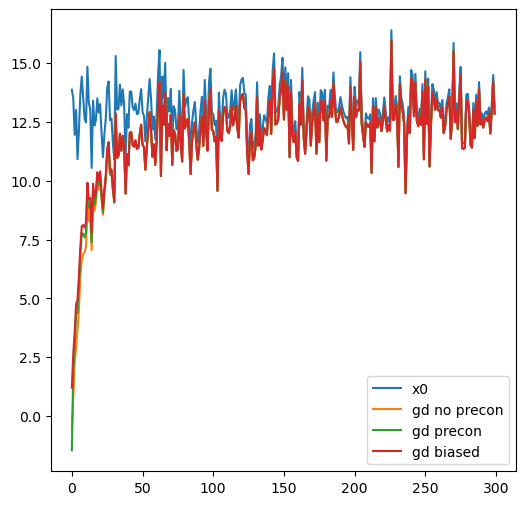

In [318]:
plt.plot(x0)
plt.plot(x_gd_noprecon)
plt.plot(x_gd)
plt.plot(x_gd_b)

plt.legend(['x0', 'gd no precon', 'gd precon', 'gd biased'])

In [19]:
print(x0[0])
print(x_gd[0])
print(x0[0]-x_gd[0])

13.86859505517294
5.9572822730668924e-15
13.868595055172934


In [20]:
print(b1sol)
print(x0[1])
print(x_gd[1])
print(x0[1]-x_gd[1])
print(err_b1_gd[-1])

3.37139582152871
13.491370420663639
1.9265118980171658
11.564858522646473
1.4448839235115443


In [21]:
print(x0[d-1])
print(x_gd[d-1])
print(x0[d-1]-x_gd[d-1])
print(f"sigma={sigma}")

13.113067440328582
12.85461904927397
0.25844839105461226
sigma=0.01


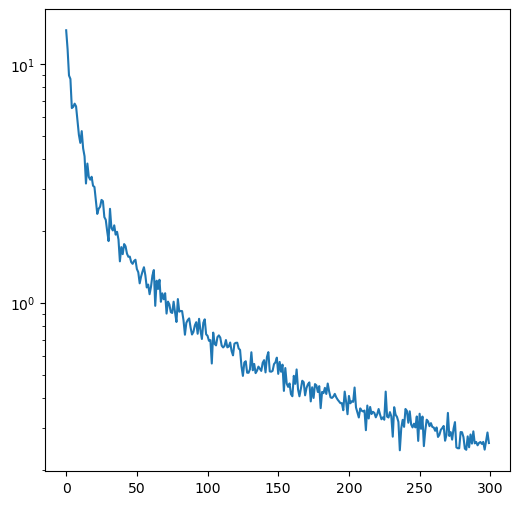

In [22]:
plt.semilogy(x0-x_gd)

### "SGD"

### No precon

In [221]:
adaptive_step_size = False

In [222]:
P = D #jnp.ones(x0.shape)

x_sgd = x_init

x_sgd_all_iter = [x_sgd]
x_sgd_all = [x_sgd]

cost_sgd_iter = [loss_sum(x_sgd, A, b, alpha)]
cost_sgd = [loss_sum(x_sgd, A, b, alpha)]

err_x_sgd = [jnp.linalg.norm(x_sgd-x0)]
err_x_sgd_iter = [jnp.linalg.norm(x_sgd-x0)]

err_b1_sgd = [b1sol - x_sgd[1]]
err_b1_sgd_iter = [b1sol - x_sgd[1]]

eta = 0.1

#eta = 1
etas = []
eta_max = 1
epochs = 15
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for i in tqdm(range(B)):
        if adaptive_step_size:
            eta = eta_max
        
        gradx0 = grad_term(x_sgd, A[i], b[i], alpha)
        fx0 = loss_term(x_sgd, A[i], b[i], alpha)
        
        x1 = x_sgd - eta * P * gradx0
        fx1 = loss_term(x1, A[i], b[i], alpha)

        if adaptive_step_size:
            while fx1 > fx0 - 0.9 * eta * jnp.real(jnp.sum(jnp.conj(gradx0) * P * gradx0)):
                eta = eta / 2
                x1 = x_sgd - eta * P * gradx0
                fx1 = loss_term(x1, A[i], b[i], alpha)

        x_sgd = x1
        
        cost_sgd_iter.append(loss_term(x_sgd, A, b, alpha))
        err_x_sgd_iter.append(jnp.linalg.norm(x_sgd-x0))
        
        err_b1_sgd_iter.append(b1sol - x_sgd[1])
        x_sgd_all_iter.append(x_sgd)
        etas.append(eta)
        
    cost_sgd.append(loss_sum(x_sgd, A, b, alpha))
    err_x_sgd.append(jnp.linalg.norm(x_sgd-x0))
    x_sgd_all.append(x_sgd)
    err_b1_sgd.append(b1sol - x_sgd[1])

    print(eta)
    
cost_sgd_iter = jnp.array(cost_sgd_iter)
cost_sgd = jnp.array(cost_sgd)

err_x_sgd = jnp.array(err_x_sgd)

err_b1_sgd_iter = jnp.array(err_b1_sgd_iter)
err_b1_sgd = jnp.array(err_b1_sgd)

etas = jnp.array(etas)

x_sgd_all = jnp.array(x_sgd_all)

Epoch 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.18it/s]


0.1
Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 108.98it/s]


0.1
Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 108.97it/s]


0.1
Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.15it/s]


0.1
Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.07it/s]


0.1
Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.27it/s]


0.1
Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.19it/s]


0.1
Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.45it/s]


0.1
Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.10it/s]


0.1
Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.62it/s]


0.1
Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.53it/s]


0.1
Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.54it/s]


0.1
Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 109.16it/s]


0.1
Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 108.61it/s]


0.1
Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 108.80it/s]


0.1


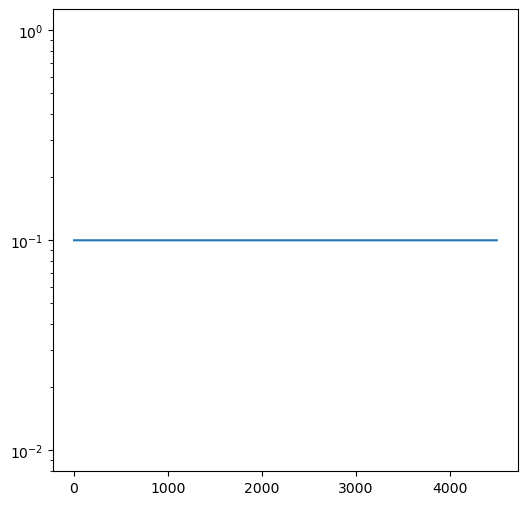

In [223]:
plt.semilogy(etas)

### Precon

In [26]:
adaptive_step_size = True

In [27]:
P = 1/D
x_sgd_p = x_init

x_sgd_p_all_iter = [x_sgd_p]
x_sgd_p_all = [x_sgd_p]

cost_sgd_p_iter = [loss_sum(x_sgd_p, A, b, alpha)]
cost_sgd_p = [loss_sum(x_sgd_p, A, b, alpha)]

err_x_sgd_p = [jnp.linalg.norm(x_sgd_p-x0)]
err_x_sgd_p_iter = [jnp.linalg.norm(x_sgd_p-x0)]

err_b1_sgd_p = [b1sol - x_sgd_p[1]]
err_b1_sgd_p_iter = [b1sol - x_sgd_p[1]]

#eta = 0.1

#eta = 100
etas = []

eta_max = 1
eta_epoch = eta_max * jnp.ones((B,))

grads = []
gradnorms = []
epochs = 30
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    
    for i in tqdm(range(B)):
        if adaptive_step_size:
            eta = eta_max
        else:
            eta = eta_epoch[i]
                    
        gradx0 = grad_term(x_sgd_p, A[i], b[i], alpha)
        fx0 = loss_term(x_sgd_p, A[i], b[i], alpha)
        
        x1 = x_sgd_p - eta * P * gradx0
        fx1 = loss_term(x1, A[i], b[i], alpha)

        if adaptive_step_size:
            while fx1 > fx0 - 0.9 * eta * jnp.real(jnp.sum(jnp.conj(gradx0) * P * gradx0)):
                eta = eta / 2
                x1 = x_sgd_p - eta * P * gradx0
                fx1 = loss_term(x1, A[i], b[i], alpha)
                
        x_sgd_p = x1
 
        cost_sgd_p_iter.append(loss_term(x_sgd_p, A, b, alpha))
        err_x_sgd_p_iter.append(jnp.linalg.norm(x_sgd_p-x0))

        err_b1_sgd_p_iter.append(b1sol - x_sgd_p[1])
        x_sgd_p_all_iter.append(x_sgd_p)

        # Actually save all the etas for each x entry 
        etas.append(eta)        
        grads.append(gradx0)
        gradnorms.append(jnp.real(jnp.sum(jnp.conj(gradx0) * P * gradx0)))

        eta_epoch = eta_epoch.at[i].set(eta)  

    cost_sgd_p.append(loss_sum(x_sgd_p, A, b, alpha))
    err_x_sgd_p.append(jnp.linalg.norm(x_sgd_p-x0))
    x_sgd_p_all.append(x_sgd_p)
    err_b1_sgd_p.append(b1sol - x_sgd_p[1])
    
cost_sgd_p_iter = jnp.array(cost_sgd_p_iter)
cost_sgd_p = jnp.array(cost_sgd_p)

err_x_sgd_p = jnp.array(err_x_sgd_p)

err_b1_sgd_p_iter = jnp.array(err_b1_sgd_p_iter)
err_b1_sgd_p = jnp.array(err_b1_sgd_p)

etas = jnp.array(etas)
grads = jnp.array(grads)
gradnorms = jnp.array(gradnorms)

x_sgd_p_all = jnp.array(x_sgd_p_all)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 99.34it/s]


Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.43it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 98.79it/s]


Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.83it/s]


Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.49it/s]


Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.13it/s]


Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.48it/s]


Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.67it/s]


Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.38it/s]


Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.63it/s]


Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.56it/s]


Epoch 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.54it/s]


Epoch 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.23it/s]


Epoch 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.60it/s]


Epoch 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.98it/s]


Epoch 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.05it/s]


Epoch 16


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.51it/s]


Epoch 17


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.14it/s]


Epoch 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.46it/s]


Epoch 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.56it/s]


Epoch 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.12it/s]


Epoch 21


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.16it/s]


Epoch 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.16it/s]


Epoch 23


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.96it/s]


Epoch 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.20it/s]


Epoch 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.47it/s]


Epoch 26


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.91it/s]


Epoch 27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.02it/s]


Epoch 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 100.99it/s]


Epoch 29


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.29it/s]


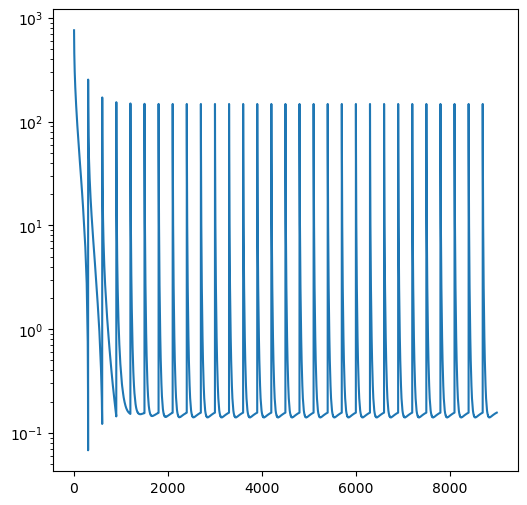

In [28]:
plt.semilogy(gradnorms)

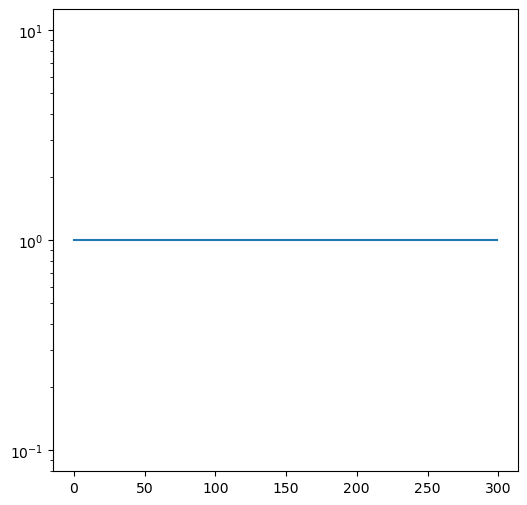

In [29]:
plt.semilogy(eta_epoch)

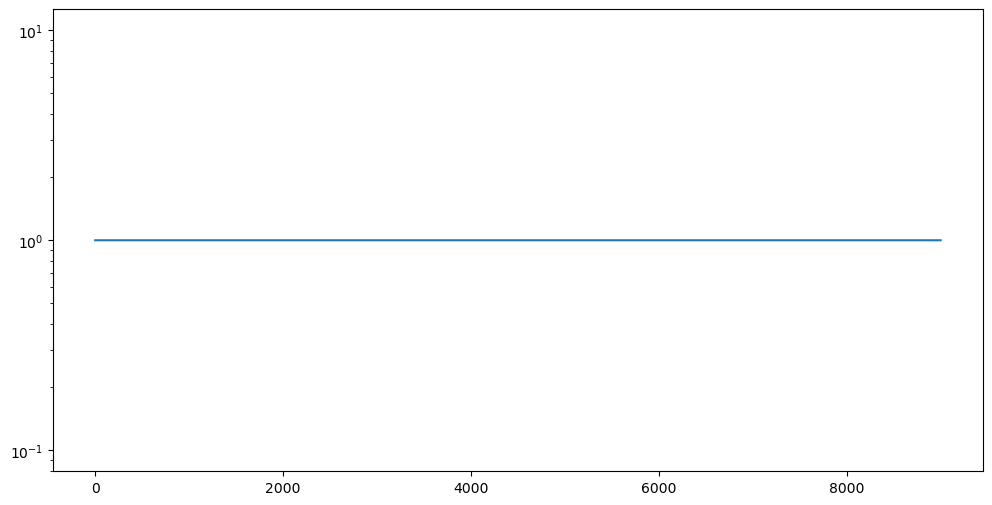

In [30]:
plt.rcParams["figure.figsize"]=12,6
plt.semilogy(etas)
plt.rcParams["figure.figsize"]=6,6


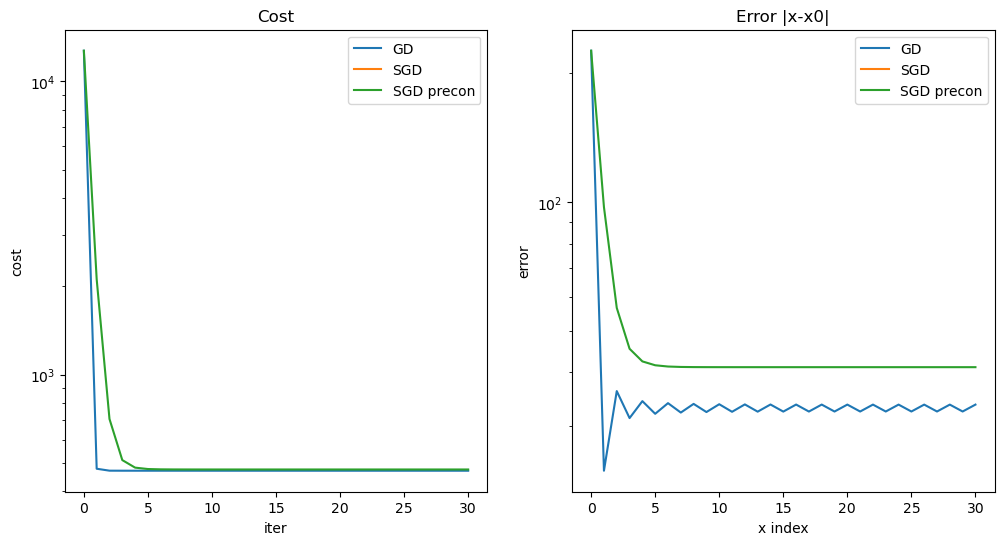

In [224]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(cost_gd)
plt.semilogy(cost_sgd)
plt.semilogy(cost_sgd_p)
plt.xlabel('iter')
plt.ylabel('cost')
plt.title('Cost')
plt.legend(['GD', 'SGD', 'SGD precon'])

plt.subplot(122)
plt.semilogy(err_x_gd)
plt.semilogy(err_x_sgd)
plt.semilogy(err_x_sgd_p)

plt.xlabel('x index')
plt.ylabel('error')
plt.title('Error |x-x0|')
plt.legend(['GD', 'SGD', 'SGD precon'])

plt.rcParams["figure.figsize"]=6,6

In [32]:
print(x0[0])
print(x_sgd[0])
print(x0[0]-x_sgd[0])

13.86859505517294
-7.186904496855137e-36
13.86859505517294


In [33]:
print(b1sol)
print(x0[1])
print(x_sgd[1])
print(x0[1]-x_sgd[1])
print(err_b1_sgd[-1])

3.37139582152871
13.491370420663639
0.007503058817693059
13.483867361845945
3.363892762711017


In [34]:
print(x0[d-1])
print(x_sgd[d-1])
print(x0[d-1]-x_sgd[d-1])
print(f"sigma={sigma}")

13.113067440328582
12.5947032444308
0.5183641958977816
sigma=0.01


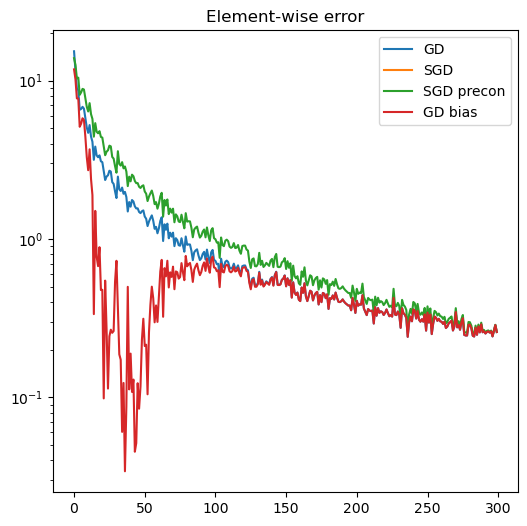

In [227]:
plt.semilogy(jnp.abs(x0-x_gd))
plt.semilogy(jnp.abs(x0-x_sgd))
plt.semilogy(jnp.abs(x0-x_sgd_p))
plt.semilogy(jnp.abs(x0-x_gd_b))



plt.title('Element-wise error')
plt.legend(['GD', 'SGD', 'SGD precon', 'GD bias'])

(31, 300)


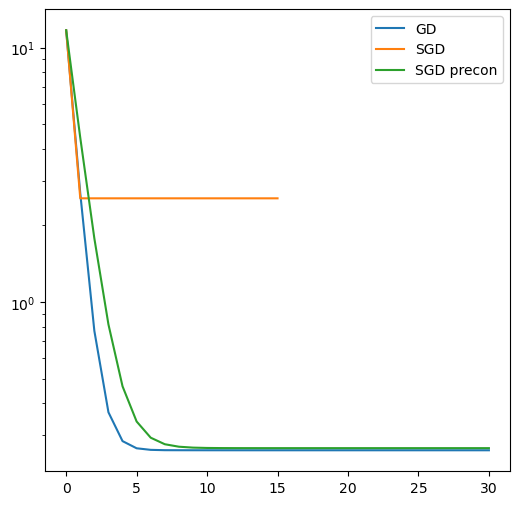

In [36]:
print(x_sgd_p_all.shape)

idx = 290
plt.semilogy(jnp.abs(x_gd_all[:,idx] - x0[idx]))
plt.semilogy(jnp.abs(x_sgd_all[:,idx] - x0[idx]))
plt.semilogy(jnp.abs(x_sgd_p_all[:,idx] - x0[idx]))

plt.legend(['GD', 'SGD', 'SGD precon'])

In [37]:
x_gd_all.shape

(31, 300)

In [38]:
idx = 50
print(sigma)
print(alpha)
print(x0[idx])
print(x_gd_all[9,idx]- x_sgd_p_all[9,idx])

0.01
0.01
12.918022291069274
0.609052272965517


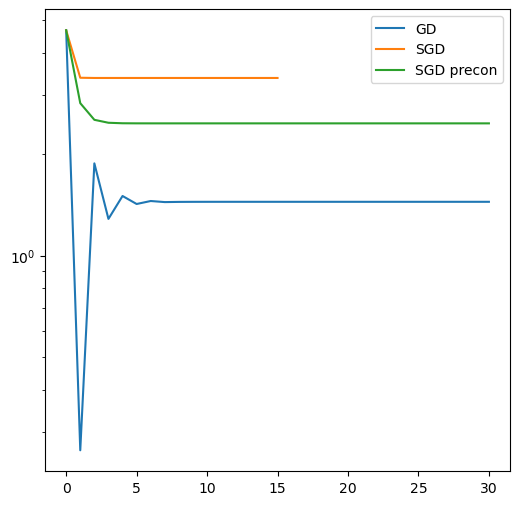

In [39]:
plt.semilogy(err_b1_gd)
plt.semilogy(err_b1_sgd)
plt.semilogy(err_b1_sgd_p)
plt.legend(['GD', 'SGD', 'SGD precon'])

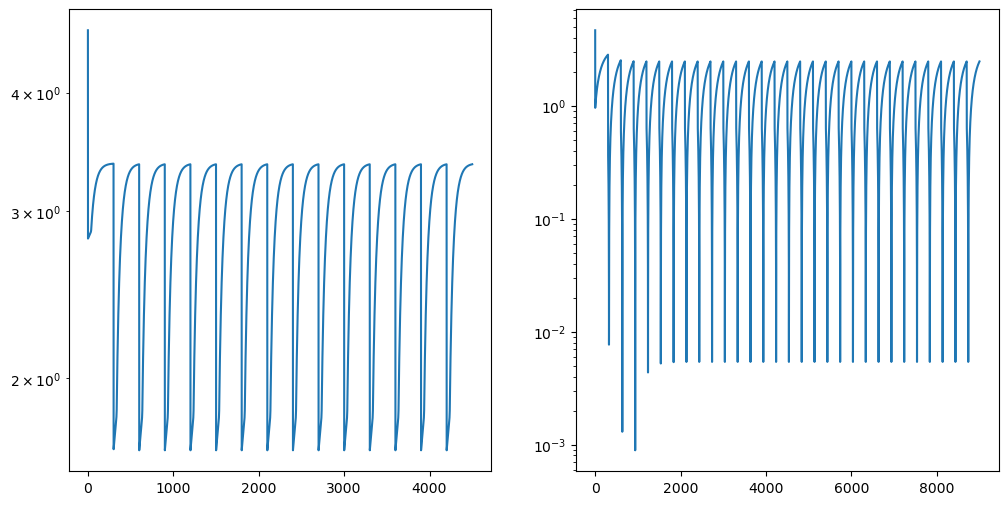

In [40]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(121)
plt.semilogy(jnp.abs(err_b1_sgd_iter))

plt.subplot(122)
plt.semilogy(jnp.abs(err_b1_sgd_p_iter))

plt.rcParams["figure.figsize"]=6,6